## Feature Engineering and Data Transformation

This notebook focuses on creating new features from the raw and preprocessed data, and then transforming the data to prepare it for machine learning models. The steps include:

-   Generating time-based features (`hour_of_day`, `day_of_week`, `time_since_signup`) for the e-commerce fraud data.
-   Calculating transaction frequency and velocity features for the e-commerce fraud data.
-   Discussing the strategy for handling class imbalance (to be implemented in the modeling phase).
-   Encoding categorical features using One-Hot Encoding.
-   Scaling numerical features using StandardScaler or MinMaxScaler.

The goal is to enrich the datasets with more predictive signals and ensure they are in a suitable format for model training.

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add the src directory to the Python path to import custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

# Import functions from data_preprocessing and feature_engineering modules
from data_preprocessing import preprocess_fraud_data, preprocess_creditcard_data, preprocess_ip_to_country_data, merge_fraud_and_ip_data
from feature_engineering import create_time_features_fraud, create_frequency_velocity_features_fraud, encode_categorical_features, scale_numerical_features
from utils import load_data, save_data

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries and custom modules loaded.")


Libraries and custom modules loaded.


#### Load and Preprocess Data
- We will load the *cleaned* datasets from the `data/` directory and then apply any necessary additional preprocessing (like merging IP data) before feature engineering.


In [2]:
# Define paths to your cleaned datasets
data_dir = '../data'
fraud_cleaned_data_path = os.path.join(data_dir, 'Fraud_Data_Cleaned.csv')
creditcard_cleaned_data_path = os.path.join(data_dir, 'creditcard_Cleaned.csv')
ip_to_country_data_path = os.path.join(data_dir, 'IpAddress_to_Country.csv') 


In [3]:
# Load cleaned datasets and raw IP to Country data
try:
    fraud_data_cleaned = load_data(fraud_cleaned_data_path)
    creditcard_data_cleaned = load_data(creditcard_cleaned_data_path)
    ip_to_country_raw = load_data(ip_to_country_data_path)
    print("\nCleaned Fraud Data and Credit Card Data loaded successfully.")
    print("Raw IP to Country Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure datasets are in the '{data_dir}' directory, including the cleaned ones.")
    raise

Successfully loaded data from '../data\Fraud_Data_Cleaned.csv'. Shape: (151112, 12)
Successfully loaded data from '../data\creditcard_Cleaned.csv'. Shape: (283726, 31)
Successfully loaded data from '../data\IpAddress_to_Country.csv'. Shape: (138846, 3)

Cleaned Fraud Data and Credit Card Data loaded successfully.
Raw IP to Country Data loaded successfully.


In [4]:
# Preprocess IP to Country data (as it might not be pre-cleaned and saved)
ip_to_country_data_processed = preprocess_ip_to_country_data(ip_to_country_raw.copy())

--- Preprocessing IP to Country Data ---
No missing values found or dropped in IP to Country Data.
No duplicate rows found or removed in IP to Country Data.
Converted 'lower_bound_ip_address' and 'upper_bound_ip_address' to integer type.
IP to Country Data preprocessing complete. New shape: (138846, 3)


In [5]:
fraud_data_cleaned.columns.tolist()  # Display columns in the cleaned fraud data

['user_id',
 'signup_time',
 'purchase_time',
 'purchase_value',
 'device_id',
 'source',
 'browser',
 'sex',
 'age',
 'ip_address',
 'class',
 'country']

In [6]:

# Merge fraud data with IP to Country data incase it is not already merged in the EDA
if 'country' not in fraud_data_cleaned.columns:
    fraud_data_merged = merge_fraud_and_ip_data(fraud_data_cleaned.copy(), ip_to_country_data_processed.copy())

    print("\n--- Data Loading and Initial Preprocessing Complete ---")
    print("\nFraud Data (after loading cleaned and merging with IP data):")
    print(fraud_data_merged.info())
    print("\nCredit Card Data (after loading cleaned):")
    print(creditcard_data_cleaned.info())
else:
    fraud_data_merged = fraud_data_cleaned.copy()
    print("\n--- Data Loading Complete ---\n")
    print("\nFraud Data (already merged with IP data):")
    print(fraud_data_merged.info())
    print("\nCredit Card Data (after loading cleaned):")
    print(creditcard_data_cleaned.info())


--- Data Loading Complete ---


Fraud Data (already merged with IP data):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_id         151112 non-null  int64 
 1   signup_time     151112 non-null  object
 2   purchase_time   151112 non-null  object
 3   purchase_value  151112 non-null  int64 
 4   device_id       151112 non-null  object
 5   source          151112 non-null  object
 6   browser         151112 non-null  object
 7   sex             151112 non-null  object
 8   age             151112 non-null  int64 
 9   ip_address      151112 non-null  int64 
 10  class           151112 non-null  int64 
 11  country         151112 non-null  object
dtypes: int64(5), object(7)
memory usage: 13.8+ MB
None

Credit Card Data (after loading cleaned):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283726 entries, 0 to 283725
Data co

In [7]:
# following some dtypes mismatch, preprocess the data again
fraud_data_merged = preprocess_fraud_data(fraud_data_merged.copy())
creditcard_data_cleaned = preprocess_creditcard_data(creditcard_data_cleaned.copy())

--- Preprocessing Fraud Data ---
No missing values found or dropped in Fraud Data.
No duplicate rows found or removed in Fraud Data.
Converted 'signup_time' and 'purchase_time' to datetime.
Converted 'ip_address' to integer type.
Fraud Data preprocessing complete. New shape: (151112, 12)
--- Preprocessing Credit Card Data ---
No missing values found or dropped in Credit Card Data.
No duplicate rows found or removed in Credit Card Data.
Credit Card Data preprocessing complete. New shape: (283726, 31)


In [8]:
print("\n--- Merged data info after preprocessing Complete ---")
fraud_data_merged.info()


--- Merged data info after preprocessing Complete ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  int64         
 10  class           151112 non-null  int64         
 11  country         151112 non-null  object        
dtypes: datetime64[ns](2), int64(5), object(5)
memory usage: 13.8+ MB


#### Feature Engineering for E-commerce Fraud Data (`fraud_data_merged`)
##### 1. Time-Based Features
- **Hypothesis:** The time of day, day of the week, and the duration between a user's signup and their first purchase might reveal patterns indicative of fraudulent behavior. For instance, fraudsters might operate at unusual hours or attempt quick purchases after signup.


In [9]:
fraud_data_engineered = create_time_features_fraud(fraud_data_merged.copy())

--- Creating Time-Based Features for E-commerce Fraud Data ---
Created 'hour_of_day'.
Created 'day_of_week'.
Created 'time_since_signup' (in seconds).
Time-based feature creation complete.


In [10]:
print("\n--- New Time-Based Features (Fraud Data) ---")
fraud_data_engineered[['purchase_time', 'signup_time', 'hour_of_day', 'day_of_week', 'time_since_signup']].head()


--- New Time-Based Features (Fraud Data) ---


,purchase_time,signup_time,hour_of_day,day_of_week,time_since_signup
0,2015-04-18 02:47:11,2015-02-24 22:55:49,2,5,4506682.0
1,2015-06-08 01:38:54,2015-06-07 20:39:50,1,0,17944.0
2,2015-01-01 18:52:45,2015-01-01 18:52:44,18,3,1.0
3,2015-05-04 13:54:50,2015-04-28 21:13:25,13,0,492085.0
4,2015-09-09 18:40:53,2015-07-21 07:09:52,18,2,4361461.0


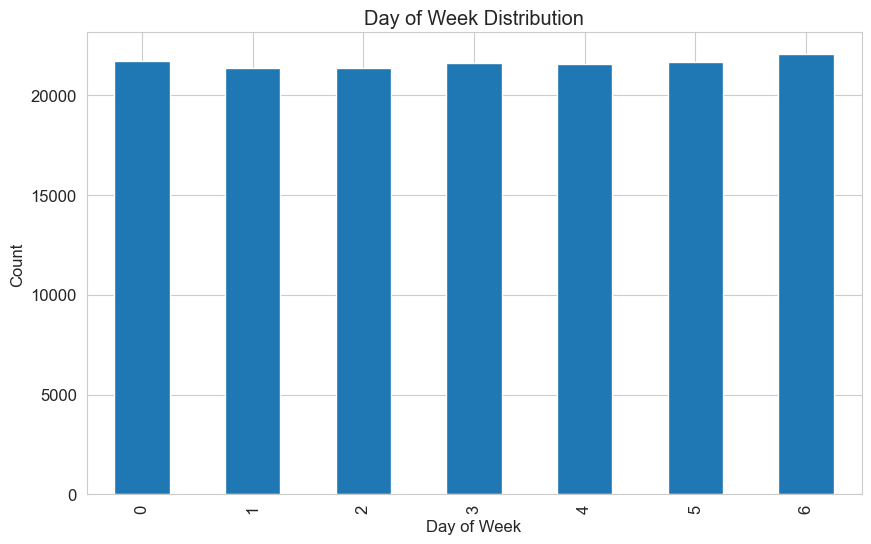

In [11]:
fraud_data_engineered.day_of_week.value_counts().sort_index().plot(kind='bar', title='Day of Week Distribution')
plt.xlabel('Day of Week')
plt.ylabel("Count")
plt.show()

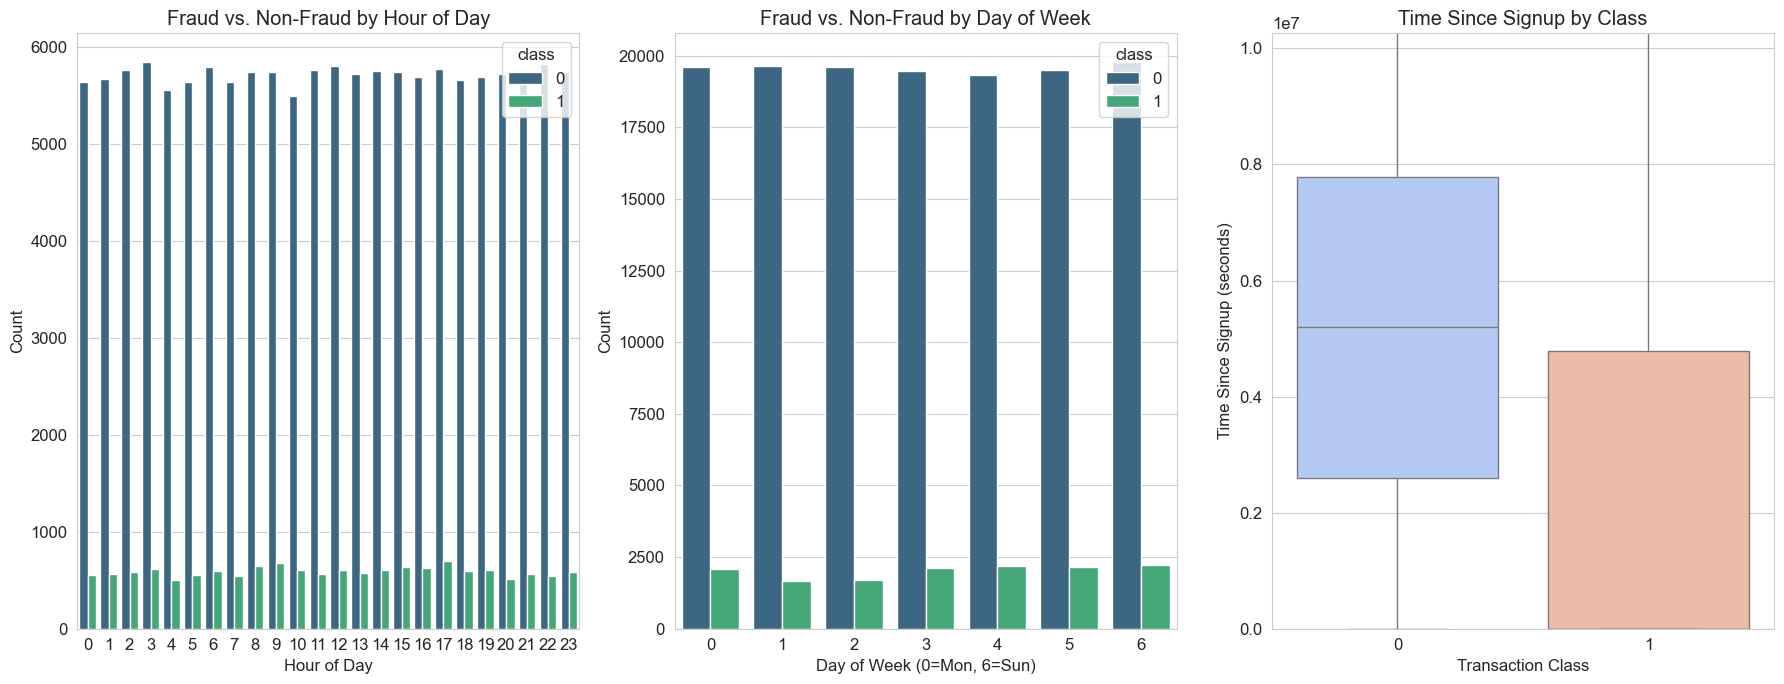

In [12]:
# Visualize new time-based features against 'class'
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

sns.countplot(x='hour_of_day', hue='class', data=fraud_data_engineered, palette='viridis', ax=axes[0])
axes[0].set_title('Fraud vs. Non-Fraud by Hour of Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Count')

sns.countplot(x='day_of_week', hue='class', data=fraud_data_engineered, palette='viridis', ax=axes[1])
axes[1].set_title('Fraud vs. Non-Fraud by Day of Week')
axes[1].set_xlabel('Day of Week (0=Mon, 6=Sun)')
axes[1].set_ylabel('Count')

sns.boxplot(x='class', y='time_since_signup', data=fraud_data_engineered, palette='coolwarm', ax=axes[2])
axes[2].set_title('Time Since Signup by Class')
axes[2].set_xlabel('Transaction Class')
axes[2].set_ylabel('Time Since Signup (seconds)')
axes[2].set_ylim(0, fraud_data_engineered['time_since_signup'].quantile(0.99)) # Limit y-axis for better visualization
plt.tight_layout()
plt.show()

##### Insights from Time-Based Features:
- **Hour of Day & Day of Week:** Fraudulent transactions might show different peak times or days compared to legitimate ones. For example, automated fraud might occur uniformly or during off-peak hours.
- **Time Since Signup:** A very short `time_since_signup` could indicate fraudulent accounts created specifically for quick illicit transactions (e.g., bot accounts). Conversely, very long times might also be suspicious if an old, dormant account is suddenly activated for fraud.

#### 2. Transaction Frequency and Velocity Features

- **Hypothesis:** Fraudulent activities often involve a high volume of transactions in a short period (velocity) or multiple transactions from a newly created account/device (frequency). These features help capture such suspicious patterns.

In [13]:
fraud_data_engineered.columns.tolist()  # Display columns after time feature engineering

['user_id',
 'signup_time',
 'purchase_time',
 'purchase_value',
 'device_id',
 'source',
 'browser',
 'sex',
 'age',
 'ip_address',
 'class',
 'country',
 'hour_of_day',
 'day_of_week',
 'time_since_signup']

In [14]:
fraud_data_engineered.dtypes  # Check data types after time feature engineering

user_id                       int64
signup_time          datetime64[ns]
purchase_time        datetime64[ns]
purchase_value                int64
device_id                    object
source                       object
browser                      object
sex                          object
age                           int64
ip_address                    int64
class                         int64
country                      object
hour_of_day                   int32
day_of_week                   int32
time_since_signup           float64
dtype: object

In [15]:
# We'll calculate velocity over a 1-hour window (3600 seconds)
fraud_data_engineerd = create_frequency_velocity_features_fraud(fraud_data_engineered.copy(), time_window_seconds=3600)

print("\n--- New Frequency and Velocity Features (Fraud Data) ---")
fraud_data_engineerd[['user_id', 'device_id', 'purchase_time', 'user_transaction_count', 'device_transaction_count', 'user_velocity', 'device_velocity']].head()

--- Creating Frequency and Velocity Features for E-commerce Fraud Data (window=1.0 hours) ---
Created 'user_transaction_count'.
Created 'device_transaction_count'.
Created 'user_velocity'.
Created 'device_velocity'.
Frequency and velocity feature creation complete.

--- New Frequency and Velocity Features (Fraud Data) ---


,user_id,device_id,purchase_time,user_transaction_count,device_transaction_count,user_velocity,device_velocity
0,22058,QVPSPJUOCKZAR,2015-04-18 02:47:11,1,1,0,0
1,333320,EOGFQPIZPYXFZ,2015-06-08 01:38:54,1,1,0,0
2,1359,YSSKYOSJHPPLJ,2015-01-01 18:52:45,1,11,0,10
3,150084,ATGTXKYKUDUQN,2015-05-04 13:54:50,1,1,0,0
4,221365,NAUITBZFJKHWW,2015-09-09 18:40:53,1,1,0,0


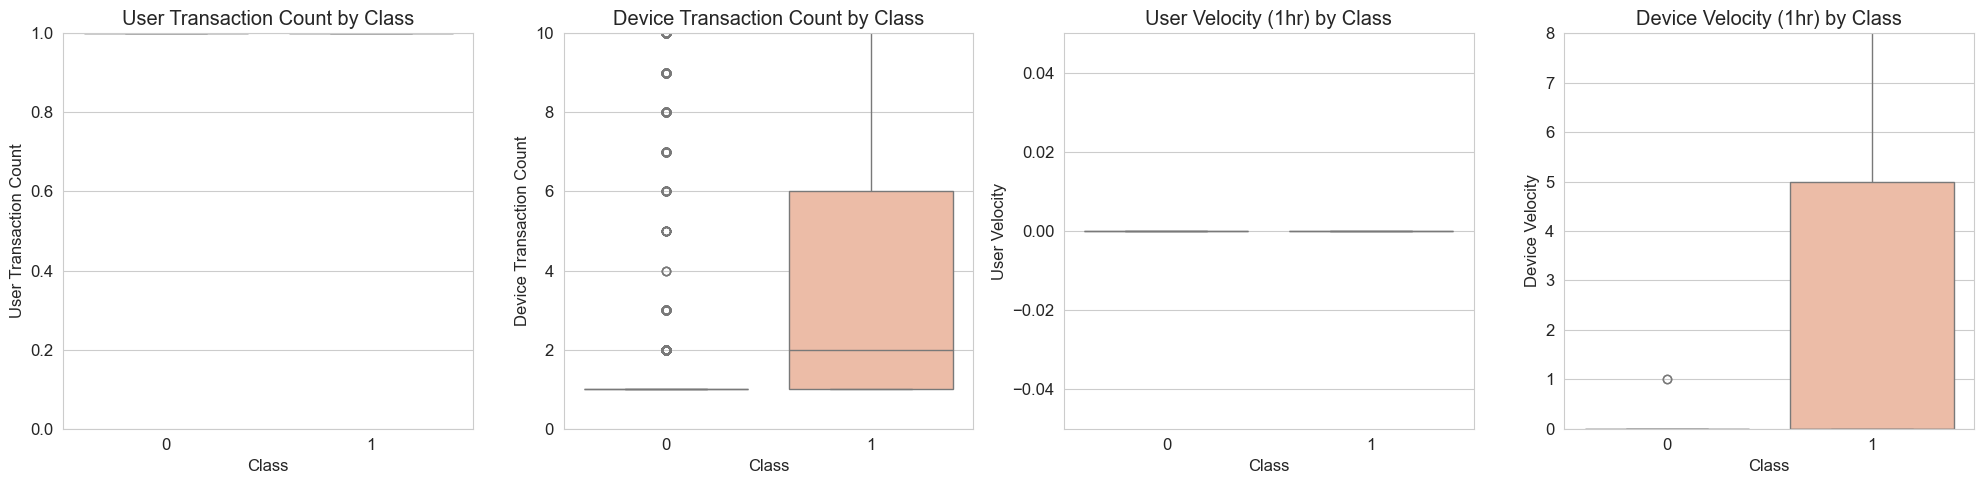

In [16]:
# Visualize new frequency/velocity features against 'class'
fraud_data_engineered = fraud_data_engineerd.copy()  
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.boxplot(x='class', y='user_transaction_count', data=fraud_data_engineered, palette='coolwarm', ax=axes[0])
axes[0].set_title('User Transaction Count by Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('User Transaction Count')
axes[0].set_ylim(0, fraud_data_engineered['user_transaction_count'].quantile(0.99))

sns.boxplot(x='class', y='device_transaction_count', data=fraud_data_engineered, palette='coolwarm', ax=axes[1])
axes[1].set_title('Device Transaction Count by Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Device Transaction Count')
axes[1].set_ylim(0, fraud_data_engineered['device_transaction_count'].quantile(0.99))

sns.boxplot(x='class', y='user_velocity', data=fraud_data_engineered, palette='coolwarm', ax=axes[2])
axes[2].set_title('User Velocity (1hr) by Class')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('User Velocity')
axes[2].set_ylim(0, fraud_data_engineered['user_velocity'].quantile(0.99))

sns.boxplot(x='class', y='device_velocity', data=fraud_data_engineered, palette='coolwarm', ax=axes[3])
axes[3].set_title('Device Velocity (1hr) by Class')
axes[3].set_xlabel('Class')
axes[3].set_ylabel('Device Velocity')
axes[3].set_ylim(0, fraud_data_engineered['device_velocity'].quantile(0.99))

plt.tight_layout()
plt.show()

In [20]:
fraud_data_engineered.head()  # Display first few rows after frequency/velocity feature engineering

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,hour_of_day,day_of_week,time_since_signup,user_transaction_count,device_transaction_count,user_velocity,device_velocity
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,2,5,4506682.0,1,1,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,1,0,17944.0,1,1,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,18,3,1.0,1,11,0,10
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,Unknown,13,0,492085.0,1,1,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,18,2,4361461.0,1,1,0,0


In [17]:
# let's see the counts etc stuff on user counts and device counts
print("\n--- User Transaction Count Statistics ---")
print(fraud_data_engineered['user_transaction_count'].describe())
print("\n--- Device Transaction Count Statistics ---")
print(fraud_data_engineered['device_transaction_count'].describe())


--- User Transaction Count Statistics ---
count    151112.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: user_transaction_count, dtype: float64

--- Device Transaction Count Statistics ---
count    151112.000000
mean          1.342183
std           1.560739
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          20.000000
Name: device_transaction_count, dtype: float64


##### Insights from Frequency and Velocity Features:
- **Transaction Counts:** Higher cumulative transaction counts for users or devices might indicate legitimate, active users, but also could highlight accounts being used for repeated fraudulent attempts.
- **Velocity Features:** A significantly higher `user_velocity` or `device_velocity` for fraudulent transactions would be a strong indicator, as fraudsters often attempt many transactions in a short burst.
- **Note**: There a lot of fraudlent transactions are performed by the same device as we see in the boxplots above in one hour window.

#### Data Transformation
##### 1. Handling Class Imbalance (Strategy Discussion)

- As identified in the EDA, both `Fraud_Data` and `Creditcard_Data` exhibit severe class imbalance, with fraudulent transactions representing a very small percentage of the total.

 **EDA Insights (from 01_EDA.ipynb):**
 - **E-commerce Fraud Data:** Approximately **9.36%** fraudulent transactions.
 - **Credit Card Fraud Data:** Approximately **0.17%** fraudulent transactions.

- This imbalance can lead to models that perform poorly on the minority class (fraud), as they tend to optimize for overall accuracy on the majority class.

- **Proposed Strategy:** To address this, we will apply **sampling techniques** to the **training data only** after the train-test split. Applying these techniques before splitting can lead to data leakage, where information from the test set (e.g., synthetic samples) influences the training process, resulting in an overly optimistic evaluation.

 **Specific Techniques to Consider (and justify in `03_Modeling.ipynb`):**
 -   **Oversampling (e.g., SMOTE - Synthetic Minority Over-sampling Technique):** Creates synthetic samples of the minority class. This is effective in increasing the representation of fraud cases without simply duplicating existing ones.
 -   **Undersampling (e.g., Random Undersampling):** Reduces the number of majority class samples. While it can balance the dataset, it risks discarding potentially useful information from the majority class.
 -   **Combination of Over- and Undersampling (e.g., SMOTE-ENN, SMOTE-Tomek):** A hybrid approach that combines the benefits of both.

 **Justification for Choice (to be elaborated in `03_Modeling.ipynb`):**
 - The choice will depend on empirical results during model training, balancing performance metrics (like AUC-PR and F1-score, which are more suitable for imbalanced data) and computational cost. SMOTE is often a good starting point for oversampling.

##### 2. Encoding Categorical Features

- Categorical features like `source`, `browser`, `sex`, and `country` need to be converted into a numerical format that machine learning models can understand. We will use One-Hot Encoding for this purpose.

In [18]:
# Identify categorical columns for Fraud Data
# Exclude 'user_id', 'device_id', 'signup_time', 'purchase_time', 'ip_address', 'class'

categorical_cols_fraud = ['source', 'browser', 'sex', 'country']

# Apply One-Hot Encoding
fraud_data_final, fraud_encoded_cols = encode_categorical_features(fraud_data_engineered.copy(), categorical_cols_fraud, strategy='onehot')

print("\n--- Fraud Data after Categorical Encoding ---")
fraud_data_final.head()



--- Encoding Categorical Features using ONEHOT Encoding ---
Encoded columns: ['source', 'browser', 'sex', 'country']
New columns created: 188

--- Fraud Data after Categorical Encoding ---


,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,hour_of_day,day_of_week,...,country_Unknown,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,39,732758368,0,2,5,...,False,False,False,False,False,False,False,False,False,False
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,53,350311387,0,1,0,...,False,False,False,False,False,False,False,False,False,False
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,53,2621473820,1,18,3,...,False,False,False,False,False,False,False,False,False,False
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,41,3840542443,0,13,0,...,True,False,False,False,False,False,False,False,False,False
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,45,415583117,0,18,2,...,False,False,False,False,False,False,False,False,False,False


In [22]:
# For Credit Card Data, there are no explicit categorical features (V1-V28 are numerical).
# If any features were identified as categorical during EDA, they would be handled here.
print("\nCredit Card Data has no explicit categorical features for encoding (V1-V28 are numerical).")


Credit Card Data has no explicit categorical features for encoding (V1-V28 are numerical).


##### 3. Scaling Numerical Features
- Numerical features often have different scales, which can negatively impact the performance of certain machine learning algorithms (e.g., Logistic Regression, SVMs, Neural Networks) that are sensitive to feature magnitudes. Scaling ensures that all features contribute equally.
- We will use `StandardScaler` which transforms data to have a mean of 0 and a standard deviation of 1.


In [ ]:
# Identify numerical columns for Fraud Data (excluding IDs and target, and original time columns)
numerical_cols_fraud = [
    'purchase_value', 'time_since_signup',
    'user_transaction_count', 'device_transaction_count',
    'user_velocity', 'device_velocity'
]

# Ensure only numeric columns are selected for scaling
numerical_cols_fraud_existing = [col for col in numerical_cols_fraud if col in fraud_data_final.columns and pd.api.types.is_numeric_dtype(fraud_data_final[col])]

# Apply Standard Scaling to Fraud Data
fraud_data_final_scaled, fraud_scaler = scale_numerical_features(fraud_data_final.copy(), numerical_cols_fraud_existing, scaler_type='standard')

print("\n--- Fraud Data after Numerical Scaling (sample of scaled columns) ---")
fraud_data_final_scaled[numerical_cols_fraud_existing].head()


--- Scaling Numerical Features using StandardScaler ---
Scaled columns: ['purchase_value', 'time_since_signup', 'user_transaction_count', 'device_transaction_count', 'user_velocity', 'device_velocity']

--- Fraud Data after Numerical Scaling (sample of scaled columns) ---


,purchase_value,time_since_signup,user_transaction_count,device_transaction_count,user_velocity,device_velocity
0,-0.160204,-0.136057,0.0,-0.219245,0.0,-0.184457
1,-1.142592,-1.571877,0.0,-0.219245,0.0,-0.184457
2,-1.197169,-1.577617,0.0,6.187996,0.0,7.161935
3,0.385567,-1.420213,0.0,-0.219245,0.0,-0.184457
4,0.112681,-0.182509,0.0,-0.219245,0.0,-0.184457


In [33]:
print("\n--- Fraud Data after Scaling Complete ---\n")  # Print after scaling 
print(fraud_data_final_scaled.info())


--- Fraud Data after Scaling Complete ---

<class 'pandas.core.frame.DataFrame'>
Index: 151112 entries, 0 to 151111
Columns: 203 entries, user_id to country_Zimbabwe
dtypes: bool(188), datetime64[ns](2), float64(6), int32(2), int64(4), object(1)
memory usage: 44.4+ MB
None


In [31]:
fraud_data_final_scaled.head()  # Display first few rows after scaling

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,hour_of_day,day_of_week,...,country_Unknown,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.160204,QVPSPJUOCKZAR,39,732758368,0,2,5,...,False,False,False,False,False,False,False,False,False,False
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.142592,EOGFQPIZPYXFZ,53,350311387,0,1,0,...,False,False,False,False,False,False,False,False,False,False
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.197169,YSSKYOSJHPPLJ,53,2621473820,1,18,3,...,False,False,False,False,False,False,False,False,False,False
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,0.385567,ATGTXKYKUDUQN,41,3840542443,0,13,0,...,True,False,False,False,False,False,False,False,False,False
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,0.112681,NAUITBZFJKHWW,45,415583117,0,18,2,...,False,False,False,False,False,False,False,False,False,False


In [34]:
# Identify numerical columns for Credit Card Data (all V features, Amount, and Time)
numerical_cols_creditcard = [col for col in creditcard_data_cleaned.columns if col.startswith('V') or col == 'Amount' or col == 'Time']

# Apply Standard Scaling to Credit Card Data
creditcard_data_final_scaled, creditcard_scaler = scale_numerical_features(creditcard_data_cleaned.copy(), numerical_cols_creditcard, scaler_type='standard')

print("\n--- Credit Card Data after Numerical Scaling (sample of scaled columns) ---")
print(creditcard_data_final_scaled.info())
print("\nDisplay first few rows of scaled numerical columns:")
creditcard_data_final_scaled[numerical_cols_creditcard].head()

--- Scaling Numerical Features using StandardScaler ---
Scaled columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

--- Credit Card Data after Numerical Scaling (sample of scaled columns) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283726 entries, 0 to 283725
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 1

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996823,-0.701082,-0.041687,1.680101,0.976623,-0.247020,0.348012,0.193700,0.084434,0.333534,...,0.326273,-0.024777,0.383483,-0.177444,0.110157,0.247059,-0.392622,0.333033,-0.065850,0.244200
1,-1.996823,0.608792,0.164138,0.109279,0.318998,0.042258,-0.060980,-0.065656,0.072903,-0.231703,...,-0.089963,-0.311372,-0.881454,0.162081,-0.561503,0.321175,0.260854,-0.027154,0.043219,-0.342584
2,-1.996802,-0.700336,-0.811337,1.174270,0.270648,-0.366756,1.352655,0.643223,0.210788,-1.381169,...,0.681564,0.343094,1.065068,1.457772,-1.138484,-0.628161,-0.288861,-0.144325,-0.183824,1.158900
3,-1.996802,-0.499064,-0.109972,1.187383,-0.608355,-0.008814,0.937245,0.192079,0.320843,-1.264664,...,-0.270428,-0.149093,0.007299,-0.305465,-1.941446,1.242487,-0.460694,0.154039,0.185687,0.139886
4,-1.996781,-0.597606,0.535539,1.025470,0.287092,-0.297036,0.072873,0.481517,-0.228725,0.747917,...,0.530343,-0.012516,1.101780,-0.220709,0.232904,-0.394800,1.041677,0.550001,0.654234,-0.073813


#### Summary of Feature Engineering and Data Transformation
- At this stage, both datasets (`fraud_data_final_scaled` and `creditcard_data_final_scaled`) are prepared with new engineered features and transformed (encoded, scaled) for model training.
- The next step will involve splitting the data into training and testing sets, and then applying class imbalance handling techniques to the training data before model building.

In [47]:
#finally, Save the processed dataframes for the next steps
# It's good practice to save intermediate processed data to avoid re-running all steps

processed_data_dir = os.path.join(data_dir, 'processed')
os.makedirs(processed_data_dir, exist_ok=True)

save_data(fraud_data_final_scaled, os.path.join(processed_data_dir, 'fraud_data_final_scaled.csv'))
# save_data(creditcard_data_final_scaled, os.path.join(processed_data_dir, 'creditcard_data_final_scaled.csv'))

print(f"\nProcessed data saved to '{processed_data_dir}'.")


Successfully saved data to '../data\processed\fraud_data_final_scaled.csv'.

Processed data saved to '../data\processed'.
